# Dopamine mediates the bidirectional update of interval timing

Anthony M.V. Jakob$^{1,2}$, John G. Mikhael$^{2,3}$, Allison E. Hamilos$^{2,3}$, John A. Assad$^{2,4}$, Samuel J. Gershman$^{5,6}$

$^1$Section of Life Sciences Engineering, École Polytechnique Fédérale de Lausanne, Switzerland  
$^2$Department of Neurobiology, Harvard Medical School, Boston, MA 02115  
$^3$MD-PhD Program, Harvard Medical School, Boston, MA 02115  
$^4$Istituto Italiano di Tecnologia, Genova, Italy  
$^5$Department of Psychology and Center for Brain Science, Harvard University, Cambridge, MA 02138  
$^6$Center for Brains, Minds and Machines, Massachusetts Institute of Technology, Cambridge, MA 02139  


In [1]:
include("src/main.jl")
include("src/fig2.jl");

In [2]:
using Printf, FileIO
using Pipe: @pipe

## Parameters

In [3]:
# include `dir_raw` and `dir_processed`
# modify `env_template.jl` and rename to `env.jl`
include("env.jl");

In [4]:
verbose = 0
const nbins = 20;

## Process raw photometry signals

In [5]:
binmode = AbsBin()
binalign = AlignLick()

dirs = readdir(dir_raw)
dirs = filter(d -> !(d in EXCLUDED_DIRS), dirs);

In [6]:
meta_all = nothing
bins_all = nothing

for dir in dirs
    meta, bins = get_bins(dir_raw * "/" * dir, nbins;
        binmode=binmode,
        binalign=binalign,
        cachedir=dir_processed,
        verbose=verbose)
    
    if !isnothing(meta) && !isnothing(bins)
        if bins_all === nothing
            meta_all = meta
            bins_all = bins
        else
            append!(meta_all, meta)
            append!(bins_all, bins)
        end
    end
end

┌ Warning: No SNc measurements found for mouse b5_day12_hybop0, skipping
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\dopa-rpe-interval-timing\src\main.jl:327
┌ Warning: More lamp_ons than cues for mouse b5_day16_allop0_file1, trimming...
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\dopa-rpe-interval-timing\src\main.jl:318
┌ Warning: No SNc measurements found for mouse b5_day16_allop0_file1, skipping
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\dopa-rpe-interval-timing\src\main.jl:327
┌ Warning: More lamp_offs than cues for mouse b5_day16_allop0_file2, trimming...
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\dopa-rpe-interval-timing\src\main.jl:314
┌ Warning: More lamp_ons than cues for mouse b5_day16_allop0_file2, trimming...
└ @ Main C:\Users\antho\Google Drive\Harvard\Thesis\Time perception\dopa-rpe-interval-timing\src\main.jl:318
┌ Warning: No SNc measurements found for mouse b5_day16_allop0

Sessions with more `lamp_off`s or `lamp_on`s than cues:
- b3_day7
- b5_day16_allop0_file1
- b5_day16_allop0_file2
- b6_day13_allop0
- b6_day14_hybop0_file2

All manually checked, we can simply remove the extra events at the end of the session.

## Figure 2AB: Compute empirical bidirectional plasticity function

In [7]:
# forward and reverse analysis
function get_coefs(lickbin; baseline_normalization=true, reverse=false)
    coefs  = zeros(nbins, length(mice))
    errors = zeros(nbins, length(mice))

    for (m, mouse) in enumerate(mice)
        coefs[:,m], errors[:,m], _, _ = get_bidirectional_fn(
            meta_all, bins_all, mouse_sessions[m];
            baseline_normalization=baseline_normalization,
            lickbin=lickbin,
            reverse=reverse)
    end
    
    coef_agg, error_agg, _, _ = get_bidirectional_fn(
        meta_all, bins_all, sessions;
        baseline_normalization=baseline_normalization,
        lickbin=lickbin,
        reverse=reverse)
    
    return hcat(coefs, coef_agg), hcat(errors, error_agg)
end;

In [8]:
sessions = unique(meta_all.session)

# sort mice by first letter, then by number
mice = unique(meta_all.mouse)
sort!(mice, by=m -> (m[1], parse(Int, m[2:end])))

# get sessions for each mouse
mouse_sessions = map(m -> filter(s -> startswith(uppercase(s), m), sessions), mice);

In [9]:
lickbin = (3.3, 7)

fig2A_coefs, fig2A_errors = get_coefs(lickbin, reverse=false)
fig2B_coefs, fig2B_errors = get_coefs(lickbin, reverse=true)
fig2AB_labels = vcat(mice, "All");

In [10]:
bintimes = get_bintimes(-mean(lickbin), 0, nbins, AbsBin(), AlignLick())
x = (bintimes[1:end-1] + bintimes[2:end]) / 2.0

fig2AB = plot_fig_2_A_B(
    x,
    fig2A_coefs, fig2A_errors,
    fig2B_coefs, fig2B_errors,
    fig2AB_labels;
    smooth_len=3
);

### Different lick intervals

In [11]:
intervals = 2.5:0.5:6.5 |> collect
interval_label(index) = "$(intervals[index]) - $(intervals[index]+0.5)s"

coefs  = zeros(nbins, length(intervals))
errors = zeros(nbins, length(intervals))

n = zeros(length(intervals))

for (i, b) in enumerate(intervals)
    coefs[:,i], errors[:,i], c, _ = get_bidirectional_fn(
        meta_all, bins_all, sessions;
        baseline_normalization=true,
        lickbin=b .+ (0, 0.5),
        reverse=false)
    
    n[i] = nrow(c)
end
;

#### Subplots

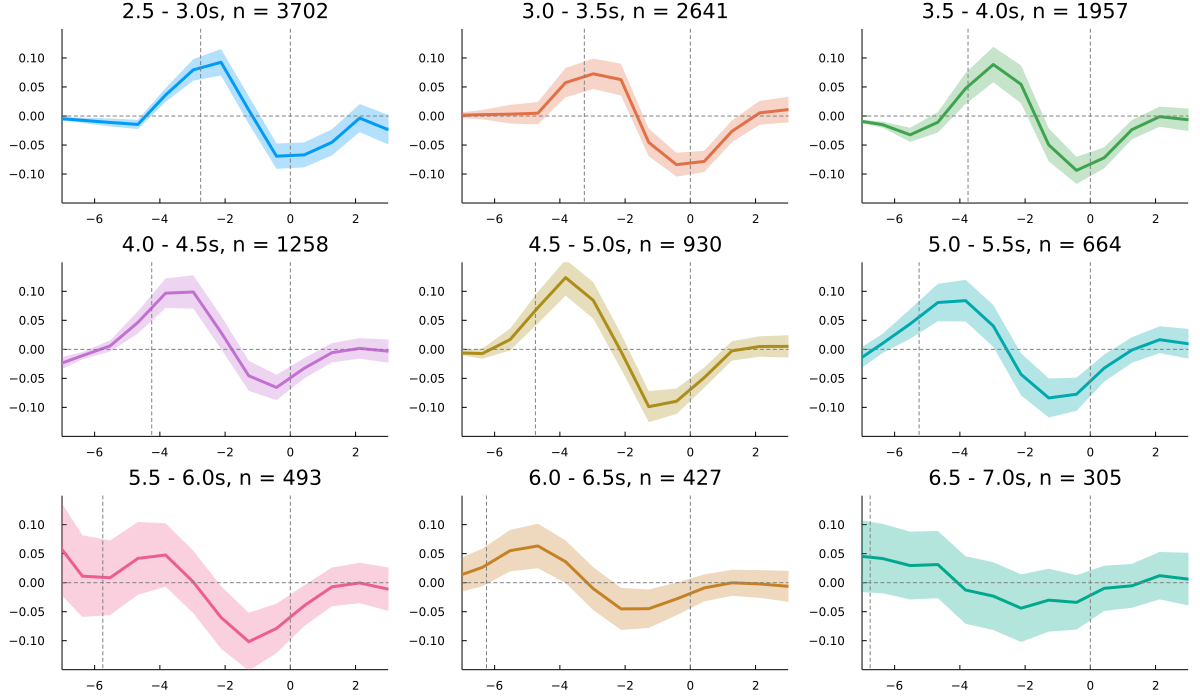

In [12]:
plots = Array{Plots.Plot}(undef, length(intervals)) # {Plots.GRBackend}
smooth_arr(arr) = smooth(arr, :rect, 3)

for i in 1:length(intervals)
    label = interval_label(i)
    
    p = plot(x, coefs[:,i] |> smooth_arr, ribbon=errors[:,i] |> smooth_arr,
        size=(800, 400),
        xlim=(-7, 3),
        ylim=(-0.15, 0.15),
        grid=:off,
        linewidth=3,
        fillalpha=0.3,
        opacity=1,
        color=i,
        legend=nothing,
        title="$label, n = $(round(Int, n[i]))"
    )

    params = Dict(:linestyle=>:dash, :color=>:grey, :label=>"")
    vline!([0, -intervals[i]-0.25]; params...)
    hline!([0]; params...)
    
    plots[i] = p
end

plot(plots..., size=(1200, 700), layout=@layout([° ° °; ° ° °; ° ° °]))

#### GIF

In [ ]:
anim = @animate for i in 1:length(intervals)
    plot()
    
    for j in 1:i-1
        plot!([],[], color=j, label=interval_label(j))
    end
    
    label = interval_label(i)
    
    plot!(x, coefs[:,i] |> smooth_arr, ribbon=errors[:,i] |> smooth_arr,
        size=(800, 400),
        xlim=(-7, 3),
        ylim=(-0.15, 0.15),
        grid=:off,
        linewidth=3,
        fillalpha=0.3,
        opacity=1,
        color=i,
        label=label,
        legend=:outerright,
        legendtitle="Intervals",
        title="Interval = $label, n = $(round(Int, n[i]))"
    )

    params = Dict(:linestyle=>:dash, :color=>:grey, :label=>"")
    vline!([0, -intervals[i]-0.25]; params...)
    hline!([0]; params...)
    
    for j in i+1:length(intervals)
        plot!([],[], color=j, label=interval_label(j))
    end
end

# gif(anim, "anim.gif", fps = 1);

### Contrast analysis

In [13]:
using HypothesisTests

In [14]:
do_ttest(coef) = OneSampleTTest(coef[4,1:end-1], coef[9,1:end-1]);

In [15]:
do_ttest(fig2A_coefs)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          0.246602
    95% confidence interval: (0.1814, 0.3118)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-05

Details:
    number of observations:   12
    t-statistic:              8.327039748737842
    degrees of freedom:       11
    empirical standard error: 0.029614560944743462


In [16]:
do_ttest(fig2B_coefs)

One sample t-test
-----------------
Population details:
    parameter of interest:   Mean
    value under h_0:         0
    point estimate:          -0.0148787
    95% confidence interval: (-0.1495, 0.1197)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8123

Details:
    number of observations:   12
    t-statistic:              -0.24325301378570227
    degrees of freedom:       11
    empirical standard error: 0.061165511641924686


## Figure 2C: Average signal after different high DA conditions

In [17]:
padding = 1
padding_ms = round(Int, padding * 1000)

dopa_maxlen = ceil(Int, 1000 * (MAX_CUE_TO_LAMP_ON + 2*padding)) + 2;

In [ ]:
dopa_all = missings(Union{Missing, Float64}, dopa_maxlen, nrow(meta_all))
dopa_idx = 1

for dir in dirs
    _, dopa = get_trial_da(dir_raw * "/" * dir;
        padding=padding,
        verbose=verbose)
    
    if !isnothing(dopa)
        ncol = size(dopa,2)
    
        dopa_all[:,dopa_idx:dopa_idx+ncol-1] .= dopa
        dopa_idx += ncol
    end    
end

In [47]:
dopa_cue  = dopa_all
dopa_lick = similar(dopa_all)

for (j, trial) in enumerate(eachrow(meta_all))
    len = round(Int, 1000 * (trial.lick - trial.cue)) + 2 * padding_ms + 2
    len = min(len, dopa_maxlen)
    dopa_lick[end-len+1:end,j] = dopa_cue[1:len,j]
end;

In [111]:
high_cue  = falses(nrow(meta_all))
high_lick = falses(nrow(meta_all))

high_cue_next  = falses(nrow(meta_all))
high_lick_next = falses(nrow(meta_all))

win = 250

for (i, trial) in enumerate(eachrow(meta_all))
    licktime = trial.lick - trial.cue
    licktime_ms = round(Int, licktime * 1000)
    
    dopa = dopa_all[:,i]
    dopa = identity.(filter(!ismissing, dopa))
    
    if 0 < licktime < 7 && licktime_ms > max(2*win, 2*padding_ms)
        icue  = 1 + padding_ms
        ilick = icue + licktime_ms        
        
        # determine high DA conditions
        μ     = mean(dopa)
        μcue  = mean(dopa[icue-win:icue+win])
        μlick = mean(dopa[ilick-win:min(ilick+win, length(dopa))])

        high_cue[i]  = μcue > μlick && μcue > μ
        high_lick[i] = μlick > μcue && μlick > μ
        
        # mark next trial if it is valid
        if i < nrow(meta_all) && meta_all.session[i+1] == trial.session && meta_all.trial[i+1] == trial.trial+1
            licktime_next = meta_all.lick[i+1] - meta_all.cue[i+1]
            
            high_cue_next[i+1]  = high_cue[i]  && 0 < licktime_next < 7
            high_lick_next[i+1] = high_lick[i] && 0 < licktime_next < 7
        end
    end
end;

#### Statistical analysis of increase vs decrease in slope

In [112]:
idx_cues =  findall(high_cue)
idx_licks = findall(high_lick)

if idx_cues[end]  == nrow(meta_all); pop!(idx_cues);  end
if idx_licks[end] == nrow(meta_all); pop!(idx_licks); end

slopes_cue  = meta_all.da_slope[idx_cues .+ 1,:] - meta_all.da_slope[idx_cues,:]
slopes_lick = meta_all.da_slope[idx_licks .+ 1,:] - meta_all.da_slope[idx_licks,:]

EqualVarianceTTest(
    vec(slopes_cue),
    vec(slopes_lick),
)

Two sample t-test (equal variance)
----------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          0.00937287
    95% confidence interval: (0.0081, 0.0107)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-43

Details:
    number of observations:   [3001,13405]
    t-statistic:              13.941551806265373
    degrees of freedom:       16404
    empirical standard error: 0.0006722976314398445


#### Align by cue

In [113]:
x = LinRange(-padding, MAX_CUE_TO_LAMP_ON + padding, size(dopa_cue,1))
lickbin = [3.3, 7];

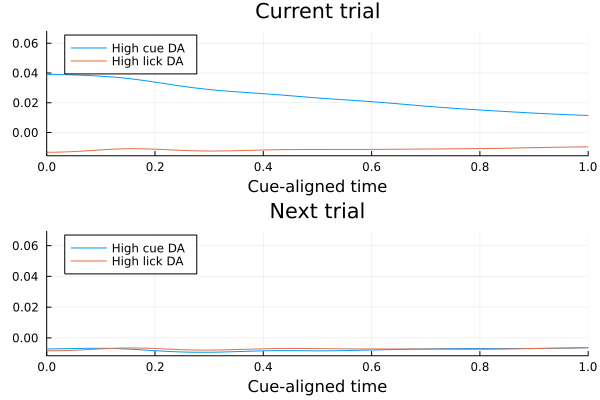

In [114]:
p1 = plot_fig2C_align_cue(x, meta_all, dopa_cue, high_cue, high_lick, lickbin)
p2 = plot_fig2C_align_cue(x, meta_all, dopa_cue, high_cue_next, high_lick_next, lickbin)

title!(p1, "Current trial")
title!(p2, "Next trial")

plot(p1, p2, layout=@layout([p1; p2]))

#### Align by lick

In [119]:
x = LinRange(-MAX_CUE_TO_LAMP_ON - padding, padding, size(dopa_lick,1))
lickbin = [3.75, 4.25];

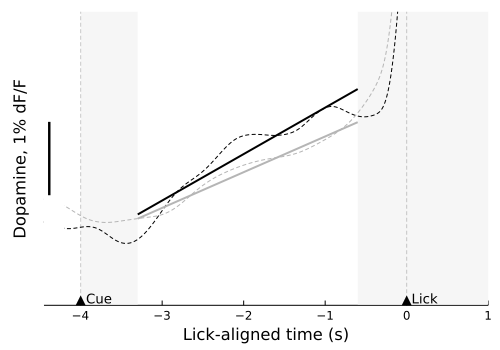

In [120]:
fig2C = plot_fig2C(x, meta_all, dopa_lick, high_cue_next, high_lick_next, lickbin, padding)

## Figure 2

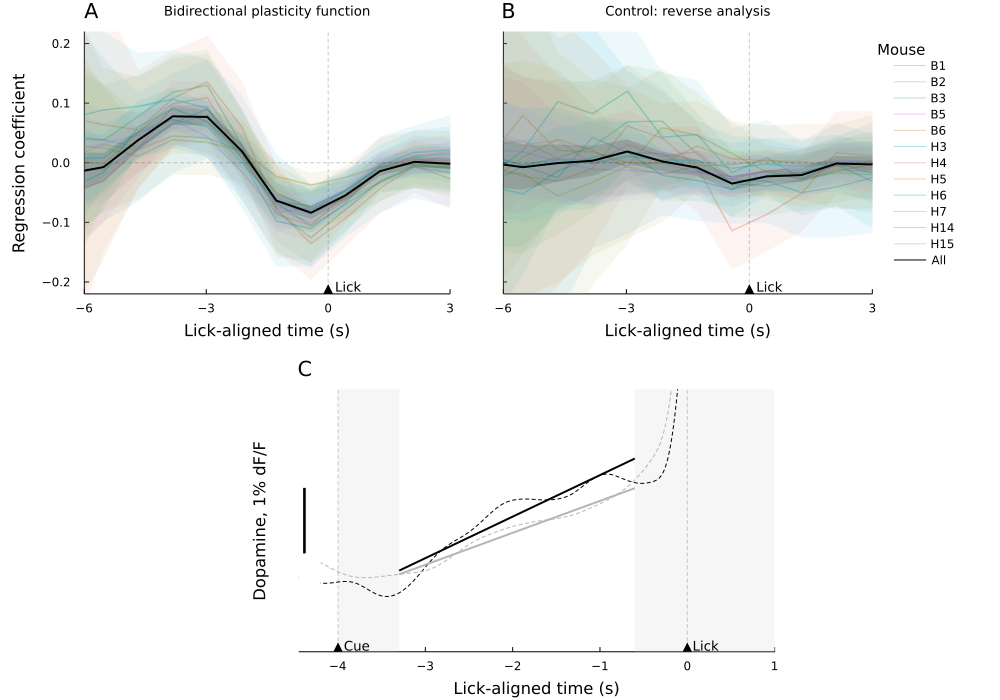

In [121]:
plot_fig2(fig2AB, fig2C)

## Categorical model

In [122]:
using CategoricalArrays

In [123]:
_, _, df, df_meta = get_bidirectional_fn(meta_all, bins_all, sessions;
    baseline_normalization=true,
    lickbin=(0, 17),
    reverse=false)

df.is_rewarded = categorical(df_meta.is_rewarded);

In [124]:
lm(@formula(a ~ 0 + is_rewarded), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

a ~ 0 + is_rewarded

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                           Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
is_rewarded: false   0.000416316  0.000160679   2.59    0.0096   0.000101383   0.000731249
is_rewarded: true   -0.00179085   0.000378464  -4.73    <1e-05  -0.00253265   -0.00104905
──────────────────────────────────────────────────────────────────────────────────────────